In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import urllib2
import csv
import seaborn as sns
import os, json, requests, pickle
import datetime as time     #for datetime operations
import time 
import matplotlib.pyplot as plt
from tabulate import tabulate
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

** Question 1 **

* Programmatically download and load into your favorite analytical tool the trip data for September 2015.
* Report how many rows and columns of data you have loaded.

In [2]:
s = time.time()
if os.path.exists('green_tripdata_2015-09.csv'): # Check if the dataset is present on local disk and load it
    nyc_data = pd.read_csv('green_tripdata_2015-09.csv')
else:
    nyc_data = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')

end = time.time()
print("Time taken by above cell is {}.".format((end-s)))

Time taken by above cell is 7.29484295845.


In [3]:
nyc_data_model=nyc_data.copy()

In [4]:
# Print the rows and columns of the dataset
print "Number of rows:", nyc_data.shape[0]
print "Number of columns: ", nyc_data.shape[1]

Number of rows: 1494926
Number of columns:  21


** Question 2 **

* Plot a histogram of the number of the trip distance ("Trip Distance").
* Report any structure you find and any hypotheses you have about that structure.

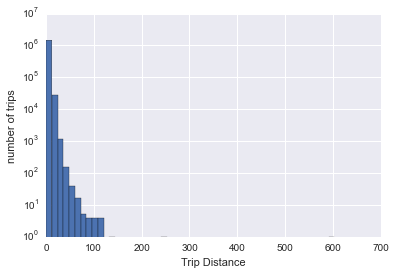

In [5]:
#nyc_data['Trip_distance'] = np.log(nyc_data['Trip_distance'].values + 1)
plt.hist(nyc_data['Trip_distance'].values, bins=50)
plt.xlabel('Trip Distance')
plt.ylabel('number of trips')
plt.yscale('log')
plt.show()

- The Trip Distance is asymmetrically distributed. It is skewed to the right and it has a median smaller than its mean and both smaller than the standard deviation. 

- Skewness could be due to outliers as well, removing outliers or by scaling (taking log of the trip distnace) can tell more about the distribution. Following two plots reveals the distribution which is lognormal in nature

** Hypothesis ** 

- The trips are not random. If there were random, we would have a (symmetric) Gaussian distribution. The non-zero autocorrelation may be related the fact that people taking ride are pushed by a common cause, for instance, people going to work or people going to holidays at start or end of the month.

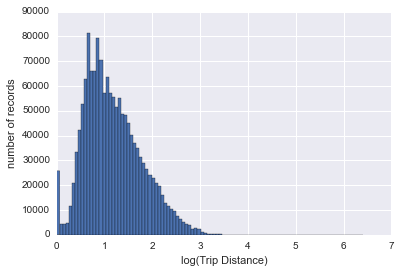

In [6]:
nyc_data['log_Trip_distance'] = np.log(nyc_data['Trip_distance'].values + 1)
plt.hist(nyc_data['log_Trip_distance'].values, bins=100)
plt.xlabel('log(Trip Distance)')
plt.ylabel('number of records')
plt.show()

Time taken by above cell is 0.446795940399.


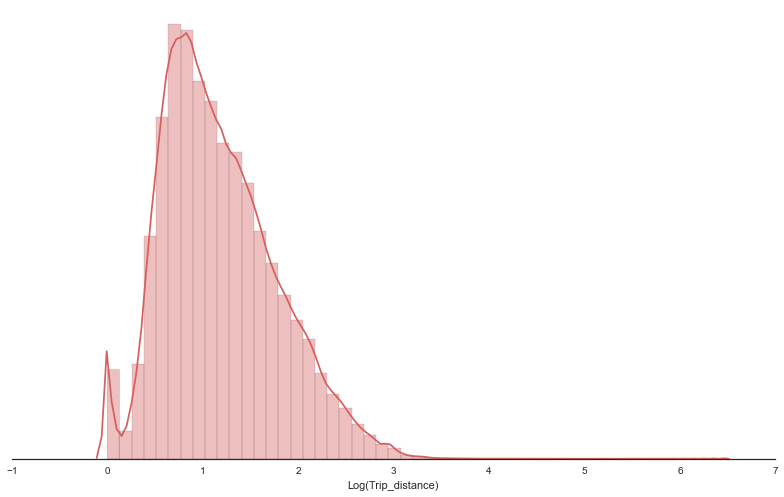

In [7]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(nyc_data['Trip_distance'].values+1), axlabel = 'Log(Trip_distance)', label = 'log(Trip_distance)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

** Question 3 **

* Report mean and median trip distance grouped by hour of day.
* We would like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. 
* Can you provide a count of how many transactions fit this criteria, the average fair, 
* and any other interesting characteristics of these trips. *

In [8]:
# Converting  pickup and drop off datetime variable in their specific right format
nyc_data['Pickup_dt'] = nyc_data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
nyc_data['Dropoff_dt'] = nyc_data.Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Second, create a variable for pickup hours
nyc_data['Pickup_hour'] = nyc_data.Pickup_dt.apply(lambda x:x.hour)

# use a pivot table to aggregate Trip_distance by hour
table_Trip_distance= nyc_data.pivot_table(index='Pickup_hour',values='Trip_distance',
                                          aggfunc=[np.mean, np.median]).reset_index()

table_Trip_distance.columns = ['Hour','Mean_distance','Median_distance']
print '-----Trip distance by hour of the day-----\n'
print tabulate(table_Trip_distance.values.tolist(),["Hour","Mean distance","Median distance"])

-----Trip distance by hour of the day-----

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.11528               2.2
     1          3.01735               2.12
     2          3.04618               2.14
     3          3.21295               2.2
     4          3.52656               2.36
     5          4.13347               2.9
     6          4.05515               2.84
     7          3.28439               2.17
     8          3.04845               1.98
     9          2.99911               1.96
    10          2.94448               1.92
    11          2.91202               1.88
    12          2.90306               1.89
    13          2.87829               1.84
    14          2.8643                1.83
    15          2.85704               1.81
    16          2.77985               1.8
    17          2.67911               1.78
    18          2.65322               1.8
    19          2.7156                1.85
    20         

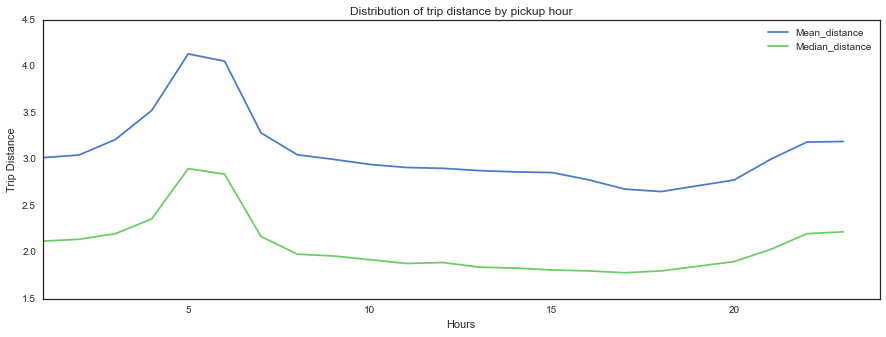

In [9]:
fig,ax = plt.subplots(1,1,figsize=(15,5)) # prepare fig to plot mean and median values
table_Trip_distance[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Trip Distance')
plt.xlabel('Hours')
plt.title('Distribution of trip distance by pickup hour')
plt.xlim([1,24])
plt.show()

- Airport trips can identified by looking at RateCodeID=2 (JFK as per data dictionary) as the only airport in 
New York City. Newark was not considered because it is a New York Metropolitan airport. There are approximately 4435
trips to/from JFK airport.

- Another way to get the airport trips would be to filter out the data for longitudes and latitudes of JFK airport
which are (40.660,-73.775) (40.635,-73.815). We may have to consider larger number of coordinates between these range
to get all the airport trips. I didn't pursued this idea due to time constraints.

- Trips starting in early hours (Around 5 am) have higher trip distances.

In [10]:
# select airport trips
jfk_trips = nyc_data[(nyc_data.RateCodeID==2)]
#airports_trips = nyc_data[(nyc_data.RateCodeID==2) | (nyc_data.RateCodeID==3)]
print "Number of trips from NYC airport (JFK): ", jfk_trips.shape[0]
print "Average fare (calculated by the meter) of trips from NYC airport (JFK): $", jfk_trips.Fare_amount.mean()
print "Average total charged amount of trips from NYC airport (JFK): $", jfk_trips.Total_amount.mean()

Number of trips from NYC airport (JFK):  4435
Average fare (calculated by the meter) of trips from NYC airport (JFK): $ 49.0218714769
Average total charged amount of trips from NYC airport (JFK): $ 56.5317091319


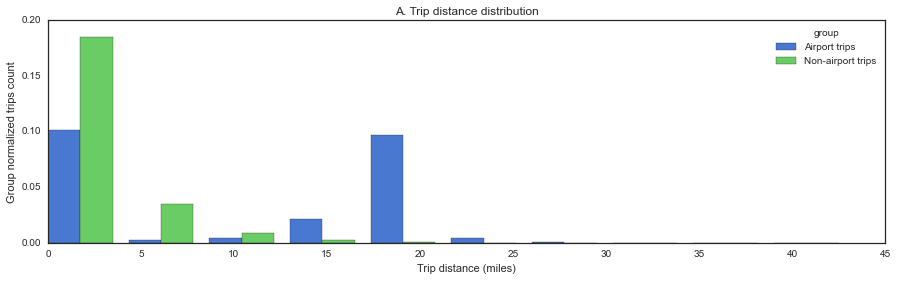

In [11]:
trips_airport  = jfk_trips.Trip_distance # airport trips
trips_non_airport = nyc_data.loc[~nyc_data.index.isin(trips_airport.index),'Trip_distance'] # non-airport trips

# define bins boundaries
bins = np.histogram(trips_airport,normed=True)[1]
h2 = np.histogram(trips_airport,bins=bins,normed=True)
h3 = np.histogram(trips_non_airport,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,1,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax.bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax.bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax.legend(['Airport trips','Non-airport trips'],loc='best',title='group')
ax.set_xlabel('Trip distance (miles)')
ax.set_ylabel('Group normalized trips count')
ax.set_title('A. Trip distance distribution')
#ax[0].set_yscale('log')


- The trip distance distribution shows two peaks. Airport trips follow the same trend as the rest of the trips for short trips (trip distance ≤ 2miles). However, there is also an increased number of long range trips (18 miles) which might correspond to a great number people coming to airports from further residential areas. 

** Question 4 **

* Build a derived variable for tip as a percentage of the total fare.
* Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). 
* We will validate a sample.

- Derived variable ('Tip_percentage') is built from the variables 'Tip_amount' and 'Total_amount'

In [12]:
nyc_data_model['Tip_percentage'] = 100*nyc_data_model.Tip_amount/nyc_data_model.Total_amount
# Replace Nan with zeroes
nyc_data_model['Tip_percentage'] = nyc_data_model['Tip_percentage'].replace(np.NaN,0)
print "Summary: Tip percentage\n",nyc_data_model.Tip_percentage.describe()

Summary: Tip percentage
count    1494926.000000
mean           6.635257
std            8.869714
min            0.000000
25%            0.000000
50%            0.000000
75%           16.666667
max          100.000000
Name: Tip_percentage, dtype: float64


### Predictive Model

#### Summary

The initial dataset contained 1494926 transactions with 21 time-series, categorical and numerical variables. Model was built in following stages:

(1) Exploratory Data Analysis

(2) Data Cleaning

(3) Feature Engineering

(4) Checking Correlation

(5) Model Creation


** (1) Exploratory Data Analysis **

- During the exploration, each variable was analyzed and compared to other variables
- Most of the categorical variables with highly skewed data were dropped because their predictability will be lower.
- Since the tip amount is available only for credit card payment type (as per data dictionary), it makes sense to build the predictive model as a regression model :
  - A regression model to find the percentage of the tip.

In [13]:
nyc_data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494926 entries, 0 to 1494925
Data columns (total 22 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

In [14]:
nyc_data_model.describe()

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,Tip_percentage
count,1494926.000000,1494926.000000,1494926.000000,1494926.000000,1494926.000000,1494926.000000,1494926.000000,1494926.000000,1494926.000000,1494926.00000,1494926.000000,1494926.000000,1494926.000000,0,1494926.000000,1494926.000000,1494926.000000,1494922.000000,1494926.000000
mean,1.782045,1.097653,-73.830839,40.691144,-73.837278,40.692905,1.370598,2.968141,12.543198,0.35128,0.486641,1.235727,0.123105,NaN,0.292099,15.032146,1.540559,1.022353,6.635257
std,0.412857,0.635944,2.776082,1.530882,2.677911,1.476698,1.039426,3.076621,10.082781,0.36631,0.085045,2.431476,0.891014,NaN,0.050740,11.553155,0.523293,0.147829,8.869714
min,1.000000,1.000000,-83.319077,0.000000,-83.427841,0.000000,0.000000,0.000000,-475.000000,-1.00000,-0.500000,-50.000000,-15.290000,NaN,-0.300000,-475.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,-73.959610,40.698952,-73.967819,40.698776,1.000000,1.100000,6.500000,0.00000,0.500000,0.000000,0.000000,NaN,0.300000,8.160000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,-73.945358,40.746738,-73.945038,40.747284,1.000000,1.980000,9.500000,0.50000,0.500000,0.000000,0.000000,NaN,0.300000,11.760000,2.000000,1.000000,0.000000
75%,2.000000,1.000000,-73.917480,40.802551,-73.910133,40.790146,1.000000,3.740000,15.500000,0.50000,0.500000,2.000000,0.000000,NaN,0.300000,18.300000,2.000000,1.000000,16.666667
max,2.000000,99.000000,0.000000,43.177261,0.000000,42.799343,9.000000,603.100000,580.500000,12.00000,0.500000,300.000000,95.750000,NaN,0.300000,581.300000,5.000000,2.000000,100.000000


In [15]:
print("Number of Nulls - {}.".format(nyc_data_model.isnull().sum().sum()))

Number of Nulls - 1494930.


RateCodeID: 
1     97.293378
5      2.270547
2      0.296670
3      0.074719
4      0.061876
6      0.002408
99     0.000401
dtype: float64

 MTA_Tax: 
 0.5    97.474457
 0.0     2.379248
-0.5     0.146295
dtype: float64


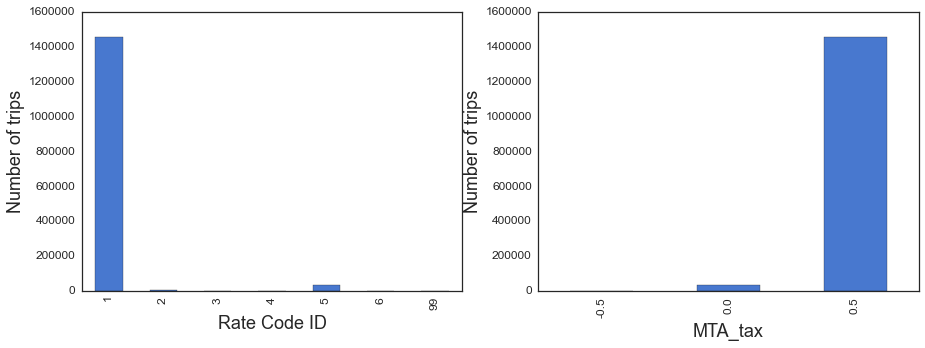

In [16]:
# Check of frequency of each categorical variables
cnt_RateCodeID= nyc_data_model.RateCodeID.value_counts()
pct_RateCodeID = (cnt_RateCodeID/cnt_RateCodeID.sum())*100
print "RateCodeID: \n",pct_RateCodeID 
cnt_MTA_tax= nyc_data_model.MTA_tax.value_counts()
pct_MTA_tax = (cnt_MTA_tax/cnt_MTA_tax.sum())*100
print "\n MTA_Tax: \n",pct_MTA_tax


fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0] = nyc_data_model.groupby(['RateCodeID']).size().plot(kind='bar',ax=ax[0])
ax[0].set_xlabel('Rate Code ID', fontsize=18)
ax[0].set_ylabel('Number of trips', fontsize=18)
ax[0].tick_params(labelsize=12)

ax[1] = nyc_data_model.groupby(['MTA_tax']).size().plot(kind='bar',ax=ax[1])
ax[1].set_xlabel('MTA_tax', fontsize=18)
ax[1].set_ylabel('Number of trips', fontsize=18)
ax[1].tick_params(labelsize=12)

In [17]:
##  replace missing values in Trip_type with the value 99
#nyc_data_model['Trip_type '] = nyc_data_model['Trip_type '].replace(np.NaN,99)


Extra: 
 0.00     45.789825
 0.50     37.889100
 1.00     16.236790
-0.50      0.059468
-1.00      0.024416
 0.25      0.000201
 0.02      0.000067
-0.72      0.000067
 12.00     0.000067
dtype: float64

 Trip_type : 
1    97.764699
2     2.235301
dtype: float64


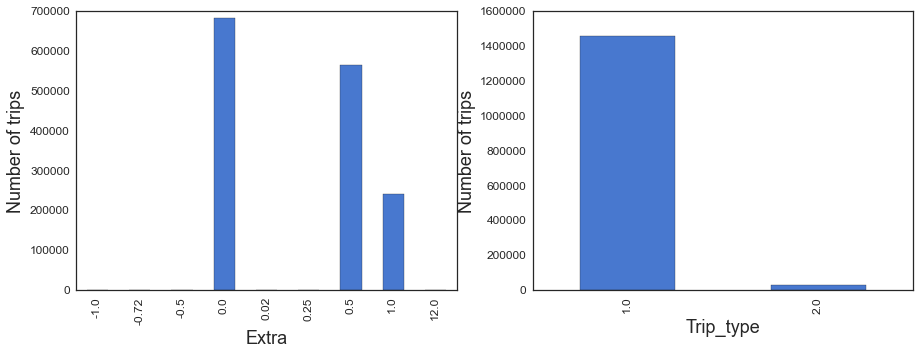

In [18]:
cnt_Extra= nyc_data_model.Extra.value_counts()
pct_Extra = (cnt_Extra/cnt_Extra.sum())*100
print "\nExtra: \n",pct_Extra
cnt_Trip_type = nyc_data_model['Trip_type '].value_counts()
pct_Trip_type = (cnt_Trip_type /cnt_Trip_type.sum())*100
print "\n Trip_type : \n",pct_Trip_type


fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0] = nyc_data_model.groupby(['Extra']).size().plot(kind='bar',ax=ax[0])
ax[0].set_xlabel('Extra', fontsize=18)
ax[0].set_ylabel('Number of trips', fontsize=18)
ax[0].tick_params(labelsize=12)

ax[1] = nyc_data_model.groupby(['Trip_type ']).size().plot(kind='bar',ax=ax[1])
ax[1].set_xlabel('Trip_type', fontsize=18)
ax[1].set_ylabel('Number of trips', fontsize=18)
ax[1].tick_params(labelsize=12)


improvement_surcharge: 
 0.3    97.514526
 0.0     2.337306
-0.3     0.148168
dtype: float64

 Store_and_fwd_flag: 
N    99.415757
Y     0.584243
dtype: float64


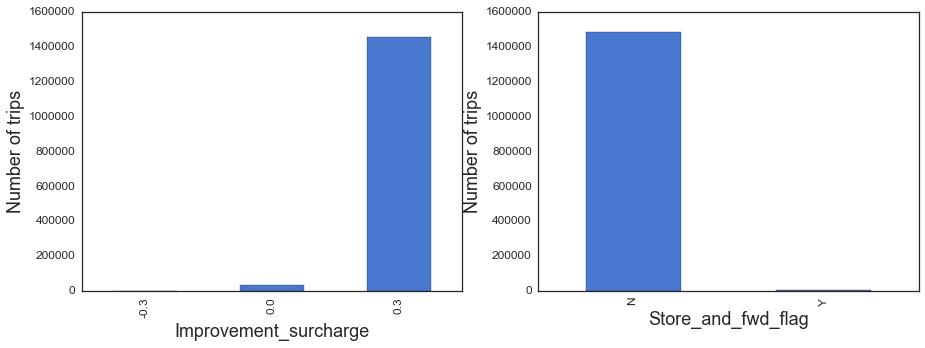

In [19]:
cnt_improvement_surcharge= nyc_data_model.improvement_surcharge.value_counts()
pct_improvement_surcharge = (cnt_improvement_surcharge/cnt_improvement_surcharge.sum())*100
print "\nimprovement_surcharge: \n",pct_improvement_surcharge
cnt_Store_and_fwd_flag= nyc_data_model.Store_and_fwd_flag.value_counts()
pct_Store_and_fwd_flag = (cnt_Store_and_fwd_flag/cnt_Store_and_fwd_flag.sum())*100
print "\n Store_and_fwd_flag: \n",pct_Store_and_fwd_flag


fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0] = nyc_data_model.groupby(['improvement_surcharge']).size().plot(kind='bar',ax=ax[0])
ax[0].set_xlabel('Improvement_surcharge', fontsize=18)
ax[0].set_ylabel('Number of trips', fontsize=18)
ax[0].tick_params(labelsize=12)

ax[1] = nyc_data_model.groupby(['Store_and_fwd_flag']).size().plot(kind='bar',ax=ax[1])
ax[1].set_xlabel('Store_and_fwd_flag', fontsize=18)
ax[1].set_ylabel('Number of trips', fontsize=18)
ax[1].tick_params(labelsize=12)


Passenger_count: 
1     97.293378
5      2.270547
2      0.296670
3      0.074719
4      0.061876
6      0.002408
99     0.000401
dtype: float64

 Payment_type: 
2    52.423933
1    46.911151
3     0.367777
4     0.292188
5     0.004950
dtype: float64


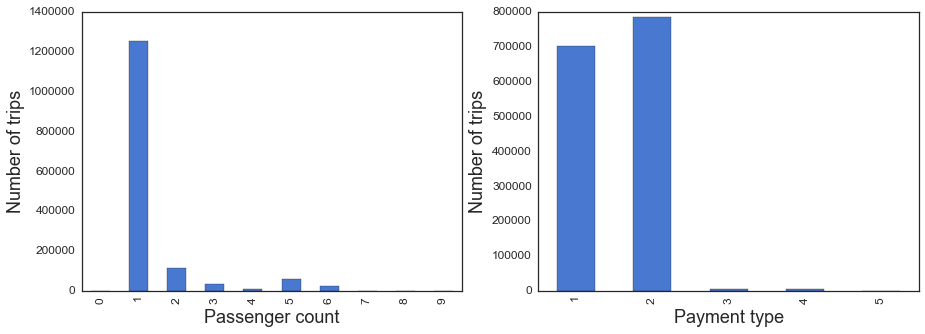

In [20]:
cnt_Passenger_count= nyc_data_model.Passenger_count.value_counts()
pct_Passenger_count = (cnt_Passenger_count/cnt_Passenger_count.sum())*100
print "\nPassenger_count: \n",pct_RateCodeID
cnt_Payment_type= nyc_data_model.Payment_type.value_counts()
pct_Payment_type = (cnt_Payment_type/cnt_Payment_type.sum())*100
print "\n Payment_type: \n",pct_Payment_type

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0] = nyc_data_model.groupby(['Passenger_count']).size().plot(kind='bar',ax=ax[0])
ax[0].set_xlabel('Passenger count', fontsize=18)
ax[0].set_ylabel('Number of trips', fontsize=18)
ax[0].tick_params(labelsize=12)

ax[1] = nyc_data_model.groupby(['Payment_type']).size().plot(kind='bar',ax=ax[1])
ax[1].set_xlabel('Payment type', fontsize=18)
ax[1].set_ylabel('Number of trips', fontsize=18)
ax[1].tick_params(labelsize=12)

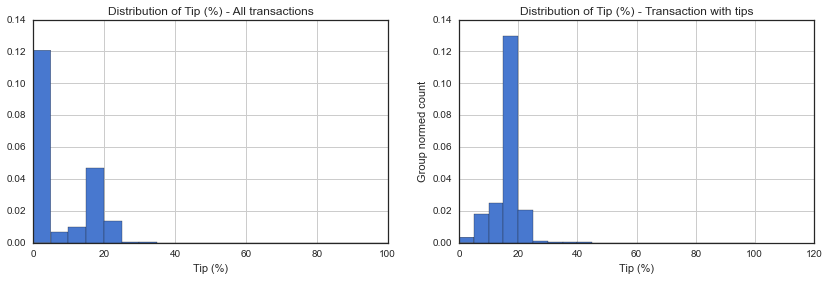

In [21]:
## code to compare the two Tip_percentage identified groups
# split data in the two groups
nyc_data_tips = nyc_data_model[nyc_data_model.Tip_percentage>0]


# generate histograms to compare
fig,ax=plt.subplots(1,2,figsize=(14,4))
nyc_data_model.Tip_percentage.hist(bins = 20,normed=True,ax=ax[0])
ax[0].set_xlabel('Tip (%)')
ax[0].set_title('Distribution of Tip (%) - All transactions')

nyc_data_tips.Tip_percentage.hist(bins = 20,normed=True,ax=ax[1])
ax[1].set_xlabel('Tip (%)')
ax[1].set_title('Distribution of Tip (%) - Transaction with tips')
ax[1].set_ylabel('Group normed count')
#plt.savefig('Question4_target_varc.jpeg',format='jpeg')
plt.show()

** (2) Data Cleaning **

- Data cleaning consisted of following steps:
- Drop variables 'Ehail_fee','MTA_tax' ,'improvement_surcharge','Store_and_fwd_flag'
- Dropping irrelevant data from 'RateCodeID'
- Replacing negative values in some variables the least value ('Total_amount' ,'Fare_amount') or zero  
- date time variables were renamed and converted in their appropriate format such datetime.

In [22]:
def data_preprocessing(df):
    
    data=df.copy()
    
    print "Started Data Preprocessing... \n"
    
    print "Dropping variables ... \n"
    ## drop Ehail_fee: 99% of its values are NaNs
    if 'Ehail_fee' in data.columns:
        data.drop('Ehail_fee',axis=1,inplace=True)
    ## drop 'MTA_tax': 97% of its values are 0.50
    if 'MTA_tax' in data.columns:
        data.drop('MTA_tax',axis=1,inplace=True)
        
    ## drop 'improvement_surcharge': 97% of its values are 0.50
    if 'improvement_surcharge' in data.columns:
        data.drop('improvement_surcharge',axis=1,inplace=True)
        
    ## drop 'Store_and_fwd_flag': 95% of its values are 0.30
    if 'Store_and_fwd_flag' in data.columns:
        data.drop('Store_and_fwd_flag',axis=1,inplace=True)
    
    print "Dropping irrelelvant data ... \n"
    ## drop 'RateCodeID'=99 (irrelevant data)
    if 'RateCodeID' in data.columns:
        data = data[data.RateCodeID != 99]
    
    print "Fixing NAN data ... \n"
        
    ##  replace missing values in Trip_type with the most frequent value 1
    data.rename(columns={'Trip_type ':'Trip_type'},inplace=True)
    data['Trip_type'] = data['Trip_type'].replace(np.NaN,1)
    
    
    print "Replacing negative data with lower bound or zero ... \n"
    ## replace all values that are not allowed as per the variable dictionary with the minimum value allowed
    data.Extra= data.Extra.clip_lower(0)
    data.Total_amount= data.Total_amount.clip_lower(2.5)
    data.Fare_amount= data.Fare_amount.clip_lower(2.5)
    data.Tip_amount= data.Tip_amount.clip_lower(0)
    data.Tolls_amount= data.Tolls_amount.clip_lower(0)
    
    # rename date variables
    print "Renaming variables... \n"
    data.rename(columns={'lpep_pickup_datetime':'Pickup_dt','Lpep_dropoff_datetime':'Dropoff_dt'},inplace=True)
    
    print "Converting Date Timestamps variables to right format ... \n"
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    
    # Trip duration 
    print "Deriving Trip_duration... \n"
    data['Trip_duration'] = (data.Dropoff_dt-data.Pickup_dt) / np.timedelta64(1, 'm')
    
    print "Dropping Trip duation less than equal to zero ... \n"
    ## drop 'RateCodeID'=99 (irrelevant data)
    if 'Trip_duration' in data.columns:
        data = data[data.Trip_duration >0]
    
    print "Data Preprocessing done... \n"
    return data  

In [23]:
nyc_data_model=data_preprocessing(nyc_data_model)

Started Data Preprocessing... 

Dropping variables ... 

Dropping irrelelvant data ... 

Fixing NAN data ... 

Replacing negative data with lower bound or zero ... 

Renaming variables... 

Converting Date Timestamps variables to right format ... 

Deriving Trip_duration... 

Dropping Trip duation less than equal to zero ... 

Data Preprocessing done... 



In [24]:
# Check data info after changes
nyc_data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493841 entries, 0 to 1494925
Data columns (total 19 columns):
VendorID             1493841 non-null int64
Pickup_dt            1493841 non-null datetime64[ns]
Dropoff_dt           1493841 non-null datetime64[ns]
RateCodeID           1493841 non-null int64
Pickup_longitude     1493841 non-null float64
Pickup_latitude      1493841 non-null float64
Dropoff_longitude    1493841 non-null float64
Dropoff_latitude     1493841 non-null float64
Passenger_count      1493841 non-null int64
Trip_distance        1493841 non-null float64
Fare_amount          1493841 non-null float64
Extra                1493841 non-null float64
Tip_amount           1493841 non-null float64
Tolls_amount         1493841 non-null float64
Total_amount         1493841 non-null float64
Payment_type         1493841 non-null int64
Trip_type            1493841 non-null float64
Tip_percentage       1493841 non-null float64
Trip_duration        1493841 non-null float64
dtypes:

In [25]:
nyc_data_model.describe()

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,Tip_amount,Tolls_amount,Total_amount,Payment_type,Trip_type,Tip_percentage,Trip_duration
count,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000,1493841.000000
mean,1.782423,1.096663,-73.835171,40.693532,-73.877596,40.715118,1.370689,2.969732,12.569660,0.351892,1.236494,0.123064,15.060670,1.540342,1.022294,6.639201,20.276704
std,0.412598,0.603105,2.717985,1.498881,2.048586,1.130130,1.039599,3.074721,9.943437,0.365263,2.431281,0.890049,11.423218,0.523323,0.147637,8.870764,96.938256
min,1.000000,1.000000,-83.319077,0.000000,-83.427841,0.000000,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,2.500000,1.000000,1.000000,0.000000,0.016667
25%,2.000000,1.000000,-73.959610,40.698982,-73.967842,40.698883,1.000000,1.100000,6.500000,0.000000,0.000000,0.000000,8.160000,1.000000,1.000000,0.000000,6.183333
50%,2.000000,1.000000,-73.945358,40.746742,-73.945061,40.747307,1.000000,1.980000,9.500000,0.500000,0.000000,0.000000,11.760000,2.000000,1.000000,0.000000,10.433333
75%,2.000000,1.000000,-73.917488,40.802551,-73.910263,40.790176,1.000000,3.740000,15.500000,0.500000,2.000000,0.000000,18.300000,2.000000,1.000000,16.666667,17.266667
max,2.000000,6.000000,0.000000,43.177261,0.000000,42.799343,9.000000,603.100000,500.000000,12.000000,300.000000,95.750000,500.000000,5.000000,2.000000,100.000000,1439.900000


** (3) Feature Engineering ** 

- The feature engineering part created 5 new variables derived from pickup and dropoff locations and timestamps


In [26]:
# Function for the feature engineering
def features_engineer(df):
    """
    This function create new variables based on present variables in the dataset adata. It creates:
    . Week: int {1,2,3,4,5}, Week a transaction was done
    . Week_day: int [0-6], day of the week a transaction was done
    . Month_day: int [0-30], day of the month a transaction was done
    . Hour: int [0-23], hour the day a transaction was done
    . Shift_type: int {1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)}, shift of the day 
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe
    """
    
    # make copy of the original dataset
    data = df.copy()
    
    # derive time variables
    print "Deriving time variables... \n"
    ref_week = dt.datetime(2015,9,1).isocalendar()[1] # first week of september in 2015
    data['Week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week+1
    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)
    #data.rename(columns={'Pickup_hour':'Hour'},inplace=True)
    
    print "Feature engineering done! :-)"
    
    return data 

In [27]:
nyc_data_model=features_engineer(nyc_data_model)

Deriving time variables... 

Feature engineering done! :-)


** (4) Checking Correlation **

- There was found no linear relationship between numerical and the target variable. 
- Some independent variables were correlated to each other. These variables were avoided in the model building.



Pickup_longitude   Pickup_latitude     0.998992
Dropoff_longitude  Dropoff_latitude    0.998168
Fare_amount        Total_amount        0.975978
Week               Month_day           0.974612
RateCodeID         Trip_type           0.962273
Trip_distance      Fare_amount         0.852572
                   Total_amount        0.848661
Payment_type       Tip_percentage      0.772396
Tip_amount         Tip_percentage      0.720456
                   Total_amount        0.578722
dtype: float64


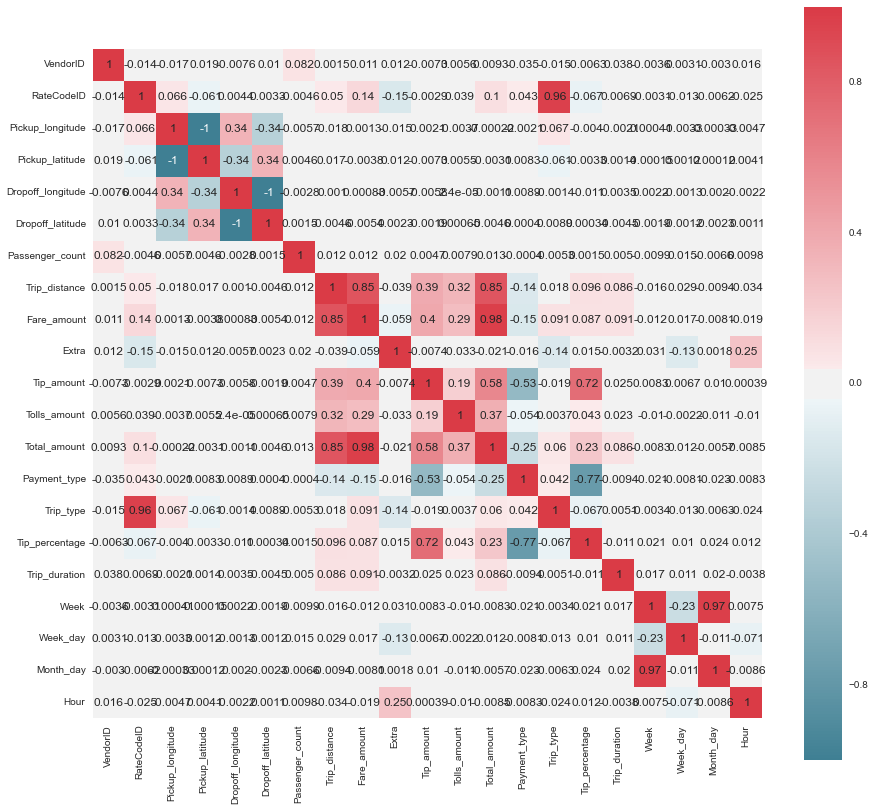

In [28]:
def plot_correlation( df ):
    corr = df.corr()
    corr_matrix = df.corr().abs()

    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    sorted_list = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .order(ascending=False))
    #first element of os series is the pair with the bigest correlation
    print sorted_list.nlargest(10)

    _ , ax = plt.subplots( figsize =( 15 , 15 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
plot_correlation(nyc_data_model)

** Correlated Pairs (non date time) **

|Variable1      |Variable2      |CORR     | Insight                                |
|---------------|:-------------:|:-------:|---------------------------------------:|
|Fare_amount    |Total_amount:  |0.975978 | Drop **Fare_amount** from the model    |
|Week           |Month_day      |0.974612 | Drop **Month_day from** the model      |
|RateCodeID     |Trip_type      |0.962273 | Drop **Trip_type from** the model      |
|Payment_type   |tip            |0.848915 | Both are derived from tip amount       | 
|Trip_distance  |Fare_amount    |0.852572 | Drop **Fare_amount** from the model    |
|Trip_distance  |Total_amount   |0.848661 | Cannot Drop
|Tip_percentage |tip            |0.910085 | Drop **Tip_percentage** from the model |
|Payment_type   |Tip_percentage | 0.772396 | Drop **Tip_percentage** from the model|

 - Insight: None of the variables except(Payment_type) are linearly correlated with 'Tip Percentage' or 'Tip'.
 - We can build a non linear model for our predictions for both classification and Regression

** (5) Model Building **

- I am going to create a regression model for predicting trip_percentage.
  
- In ideal scenario, I would have chosen atleast 3 differnt algorithms to build my model and would have selected the best model based on training error. However due to the time constraint I am using one algorithm for regression.
- I chose ** gradient boosting regression ** algorithms in sklearn with ** Gridserach ** to optimize best parameters. 
- In ideal scenario, I would have developed a seperate classification model for classifying tips or not. However in this dataset tips are only available for credit card payment type. So classification will involve separate classification models for payment credit card and non credit card payment. Looking at the time available I let go of classification idea however I would like to pursue that in my spare time.

In [29]:
# Final check to see if there is any missing data
print("Number of Nulls - {}.".format(nyc_data_model.isnull().sum().sum()))

Number of Nulls - 0.


In [30]:
# A function to train models and perform crossvalidation

# Adapted from:https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def modelfit(alg,X_train, X_test, y_train, y_test,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """
    This functions train the model given as 'alg' (algorithm) by performing cross-validation. 
    It works on both regression and classification
    alg: sklearn algorithm
    X_train, X_test, y_train, y_test: pandas.DataFrame, training set and test sets
    scoring_method: str, method to be used by the cross-validation to valuate the model
    performCV: bool, perform Cross validation or not
    printFeatureImportance: bool, plot histogram of features importance or not
    cv_folds: int, degree of cross-validation
    """
    # train the algorithm on data
    alg.fit(X_train,y_train)
    #predict on train set:
    predictions = alg.predict(X_test)
    if scoring_method == 'roc_auc':
        predprob = alg.predict_proba(X_test)[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_val_score(alg,X_train,y_train,cv=cv_folds,scoring=scoring_method)
        #print model report
        print "\nModel report:"
        if scoring_method == 'roc_auc':
            print "Accuracy        :",metrics.accuracy_score(y_test,predictions)
            print "Precision Score :",metrics.precision_score(y_test,predictions)
            print "Recall Score    :",metrics.recall_score(y_test,predictions)
            print "F1 Score        :",metrics.f1_score(y_test,predictions)
            print "AUC Score       :",metrics.roc_auc_score(y_test, predprob)
            
        if (scoring_method == 'neg_mean_squared_error'):
            print "Neg Mean_Squared_Error:",metrics.mean_squared_error(y_test,predictions)
            print "R Square:",metrics.r2_score(y_test,predictions)
            
    if performCV:
        print "CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    #print feature importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,predictors)
        #feat_imp = pd.Series(alg.feature_importances_,predictors).sort(ascending=False)
        #feat_imp = alg.feature_importances_
        
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importances Score')
        plt.show()

        
def optimize_parameters(alg,param_test,scoring_method,X_train,y_train):
    """
    This functions is used to tune paremeters of a predictive algorithm
    alg: sklearn algorithm,
    param_test: dict, parameters to be tuned
    scoring_method: str, method to be used by the cross-validation to valuate the model
    X_train,y_train: pandas.DataFrame, training set and test set
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(X_train, y_train)
    return gsearch


** Regression Model **


Model report:
Neg Mean_Squared_Error: 14.938542184214741
R Square: 0.8100089682882022
CV Score - Mean : -14.52953 | Std : 0.1832001 | Min : -14.82001 | Max : -14.26722


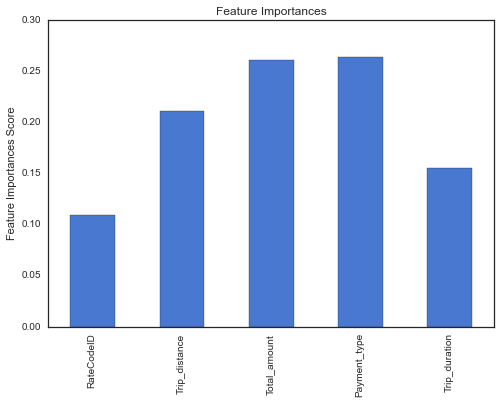

In [34]:
# import scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn import model_selection   #model optimization and valuation tools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

from sklearn.metrics import mean_squared_error, r2_score

## Getting a sample of 500,000 trips from the data.
sample_reg = nyc_data_model.loc[np.random.choice(nyc_data_model.index,size=500000,replace=False)]

predictors_itr1 = ['RateCodeID','Passenger_count','Trip_distance','Fare_amount','Extra',
              'Tolls_amount','Payment_type','Trip_duration','Week','Week_day','Hour','Shift_type']

predictors_itr2 = ['RateCodeID','Passenger_count','Trip_distance','Total_amount',
                    'Tolls_amount','Trip_duration','Week_day','Hour']

# Final set of predictors after iterations

predictors = ['RateCodeID','Trip_distance','Total_amount','Payment_type','Trip_duration']

target = ['Tip_percentage']

X_train, X_test, y_train, y_test = train_test_split(sample_reg[predictors], sample_reg[target], 
                                                    test_size=0.20,random_state=9)

#params_test = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}


xgb_rgs = GradientBoostingRegressor()

params = {'n_estimators': range(30,150,10)}

# get results of the search grid
gs_rgs = optimize_parameters(xgb_rgs,params,'neg_mean_squared_error',X_train, y_train['Tip_percentage'])

modelfit(gs_rgs.best_estimator_,X_train, X_test, y_train['Tip_percentage'], y_test['Tip_percentage'],
         scoring_method ='neg_mean_squared_error')


** (5) Final Model and Validation **

In [35]:
# testing on a different set
indices = nyc_data_model.index[~nyc_data_model.index.isin(sample_reg.index)]
test_set = nyc_data_model.loc[np.random.choice(indices,size = 500000,replace=False)]
regs_predictors = ['RateCodeID','Trip_distance','Total_amount','Payment_type','Trip_duration']
ypred = gs_rgs.best_estimator_.predict(test_set[regs_predictors])
print "final mean_squared_error:", metrics.mean_squared_error(ypred,test_set.Tip_percentage)
print "final r2_score:", metrics.r2_score(ypred,test_set.Tip_percentage)

final mean_squared_error: 14.904246255562201
final r2_score: 0.7381321128778715


** Normal Probability plot for Residuals **

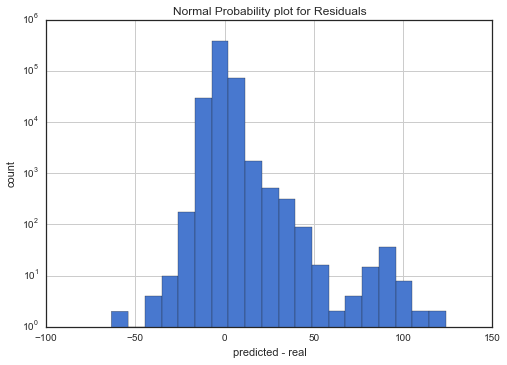

In [36]:
df = test_set.copy() # make a copy of data
df['predictions'] = ypred # add predictions column
df['residuals'] = df.Tip_percentage - df.predictions # calculate residuals

df.residuals.hist(bins = 20) # plot histogram of residuals
plt.yscale('log')
plt.xlabel('predicted - real')
plt.ylabel('count')
plt.title('Normal Probability plot for Residuals')
plt.show()

- Residuals are centered around zero indicating that model is random and not biased
- There are two peaks suggesting some cash payments might not be predicted correctly.


** Residual Analysis **

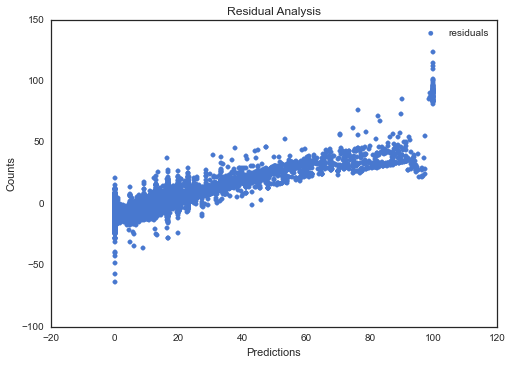

In [37]:
# Tip Percentage vs residuals

residuals = df['Tip_percentage'].values - ypred # calculate residuals
plt.scatter( df.Tip_percentage,residuals, color='b', label='residuals')
plt.xlabel('Predictions')
plt.ylabel('Counts')
plt.title('Residual Analysis')
plt.legend()
plt.show()

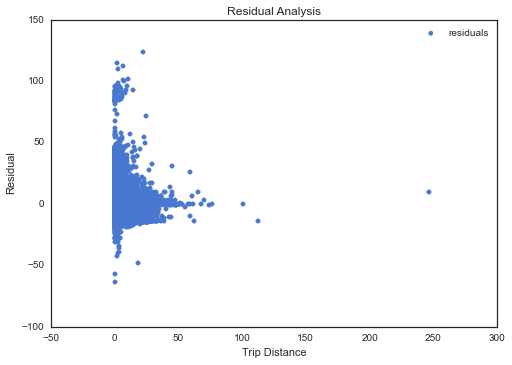

In [38]:
# Trip_distance vs Residuals

plt.scatter( df.Trip_distance,residuals, color='b', label='residuals')
plt.xlabel('Trip Distance')
plt.ylabel('Residual')
plt.title('Residual Analysis')
plt.legend()
plt.show()

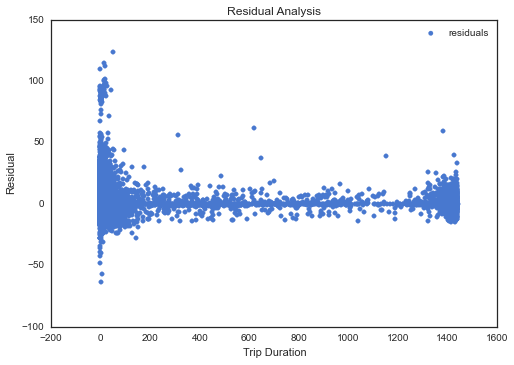

In [39]:
# Trip Duration vs Residuals

plt.scatter( df.Trip_duration,residuals, color='b', label='residuals')
plt.xlabel('Trip Duration')
plt.ylabel('Residual')
plt.title('Residual Analysis')
plt.legend()
plt.show()

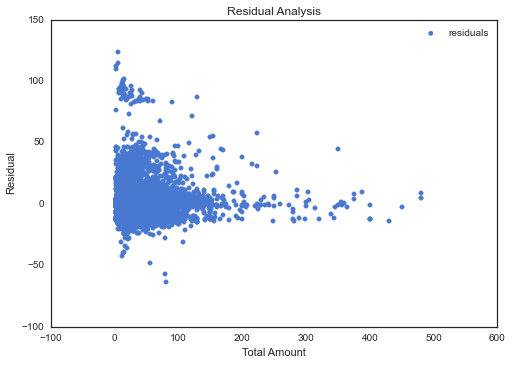

In [40]:
# Total Amount vs Residuals

plt.scatter( df.Total_amount,residuals, color='b', label='residuals')
plt.xlabel('Total Amount')
plt.ylabel('Residual')
plt.title('Residual Analysis')
plt.legend()
plt.show()

- Residuals are centered around zero but not dense indicating a log-normal distribution.
- Residuals also have non linear relationships with predictors thereby confirming our choice of non ensemble algorithm.

** Question 5 **

Choose only one of these options to answer for Question 5. 
There is no preference as to which one you choose. 
Please select the question that you feel your particular skills and/or expertise are best suited to. 
If you answer more than one, only the first will be scored.

** Option A: Distributions **

Build a derived variable representing the average speed over the course of a trip.
Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? 
If you decide they are not the same, can you form a hypothesis regarding why they differ?
Can you build up a hypothesis of average trip speed as a function of time of day?


    - Let's build a derived variable ('Avg_Speed') for the average speed for the trip
    
    - I  perform an Anova test to determine if the average speeds are same in all weeks of September.
    
    - The null hypothesis for Anova test is that the mean is the same across avergae speeds over weeks of September. To reject the null hypothesis we need to look at p-values. 
    
** Looking at the results of Anova test, we see that we don't have enough evidence at 95% level of confidence (p-values<0.05) hence we fail to reject the null hypothesis. So we can reject the null hypothesis and say that they are significantly different. **

** Average speed is higher in week 1 and week 4 thereby indicating that more people travelled to airport during morning time (highest speed by hour). Looking more closely at the hourly average speed can throw more light on this. In general, the speed can be dependent of the week of the month. It would be interesting to look at data of preceding and succeeding month as well.  **

In [41]:
# create variable for Speed
print "Create variable for Average Speed"
nyc_data_model['Avg_Speed'] = nyc_data_model.Trip_distance/(nyc_data_model.Trip_duration/60)

# replace all NaNs values and values >240mph by a values sampled from a random distribution of 
# mean 12.9 and  standard deviation 6.8mph. These values were extracted from the distribution

indices_oi = nyc_data_model[(nyc_data_model.Avg_Speed.isnull()) | (nyc_data_model.Avg_Speed>65)].index

nyc_data_model.loc[indices_oi,'Avg_Speed'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))

Create variable for Average Speed


Average speed by week:
      Avg_Speed
Week           
1     13.250154
2     12.591758
3     12.591449
4     13.063090
5     12.395942


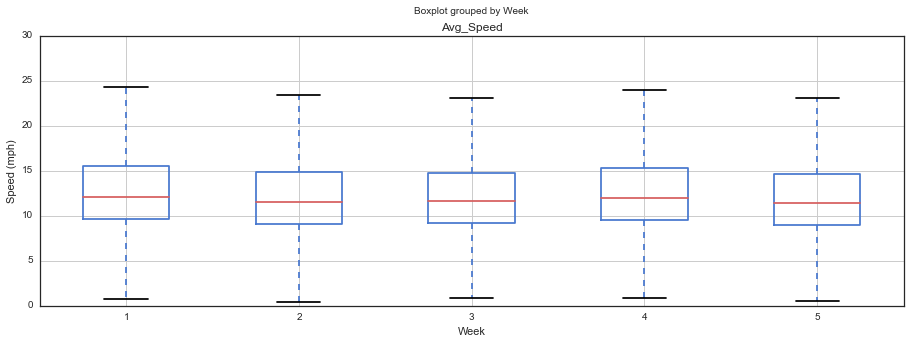

In [42]:
print "Average speed by week:\n", nyc_data_model[['Avg_Speed','Week']].groupby('Week').mean()
# generate boxplot
nyc_data_model.boxplot('Avg_Speed','Week',figsize=(15,5))
plt.ylim([0,30]) # cut off outliers
plt.ylabel('Speed (mph)')
plt.show()

Average speed by Hour:
      Avg_Speed
Hour           
0     14.515735
1     14.759076
2     14.966656
3     15.341016
4     16.134665
5     17.827299
6     16.881193
7     13.398130
8     12.225937
9     12.479538
10    12.465492
11    12.167911
12    12.074614
13    11.978595
14    11.488129
15    11.122105
16    10.886361
17    10.878194
18    11.465426
19    12.005496
20    12.696620
21    13.544099
22    14.007894
23    14.286572


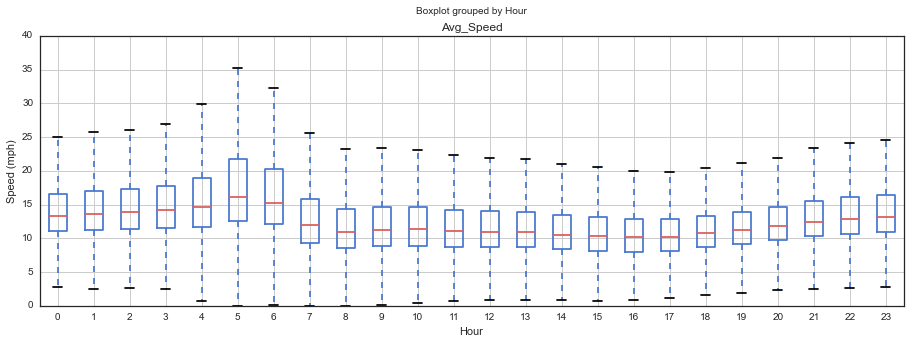

In [43]:
print "Average speed by Hour:\n", nyc_data_model[['Avg_Speed','Hour']].groupby('Hour').mean()
# generate boxplot
nyc_data_model.boxplot('Avg_Speed','Hour',figsize=(15,5))
plt.ylim([0,40]) # cut off outliers
plt.ylabel('Speed (mph)')
plt.show()

** ANOVA test for comparing average speed across Weeks and Hour **

In [48]:
import scipy.stats as stats
# calculate anova for Average speed in weeks of September
week = range(1,5)
anv = "stats.f_oneway("
for w in week:
    anv+="nyc_data_model[nyc_data_model.Week=="+str(w)+"].Avg_Speed,"
anv=anv[:-1]+")"

print "one way anova test:", eval(anv) #evaluate the command and print


 one way anova test: F_onewayResult(statistic=1062.0950201470832, pvalue=0.0)


In [49]:
# calculate anova for Average speed in hours of September
hours = range(0,23)
anv = "stats.f_oneway("
for h in hours:
    anv+="nyc_data_model[nyc_data_model.Hour=="+str(h)+"].Avg_Speed,"
anv=anv[:-1]+")"
print "one way anova test:", eval(anv) #evaluate the command and print

one way anova test: F_onewayResult(statistic=4708.955890030175, pvalue=0.0)
